In [1]:
import glob, os
from random import *
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import time, math
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data.distributed import DistributedSampler


import torchio as tio

from monai.config import print_config
from monai.data import CacheDataset, DataLoader, partition_dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete, Compose, LoadNiftid, ToTensord, AddChanneld, LabelToContour,
)
from monai.networks.blocks import Convolution, Upsample
from monai.networks.layers.factories import Pool, Act
from monai.networks.layers import split_args
from monai.utils import set_determinism
from monai.optimizers import Novograd

print_config()
print('TorchIO version:', tio.__version__)

MONAI version: 0.4.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.55.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

TorchIO version: 0.18.15


In [2]:
os.environ["MONAI_DATA_DIRECTORY"] = "./data"
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = directory
print(root_dir)

./data


In [3]:
data_dir = os.path.join(root_dir, "nifti_data")
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "mask", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [4]:
### hyperparameter setting

bs = 4
Height = 128
Width = 128
Depth = 16
fast = False
multi_GPU = True

In [5]:
### image augmentation transform with monai and torchio API

# HistogramStandardization parameter calculation
histogram_landmarks_path = 'landmarks.npy'
landmarks = tio.HistogramStandardization.train(
    train_images,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

# transform setting
train_transforms_monai = [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
]

train_transforms_io = [
        tio.CropOrPad((Height, Width, Depth),mask_name='label', include=["image", "label"]),
        tio.HistogramStandardization({'image': landmarks}, include=["image"]),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
        tio.RandomNoise(p=0.1, include=["image"]),
        tio.RandomFlip(axes=(0,), include=["image", "label"]),
]

validation_transforms_monai = [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
]

validation_transforms_io = [
    tio.CropOrPad((Height, Width, Depth), include=["image", "label"], mask_name='label'),
    tio.HistogramStandardization({'image': landmarks}, include=["image"]),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
]

# transform composition
train_transforms = Compose(train_transforms_monai + train_transforms_io)
val_transforms = Compose(validation_transforms_monai + validation_transforms_io )

100%|██████████| 99/99 [00:41<00:00,  2.41it/s]
Trained landmarks: [  0.      3.018   7.291   9.563  11.927  17.35   25.007  34.854  45.461
  50.772  56.081  67.786 100.   ]



In [6]:
## train dataset using MONAI cachedataset for speed-up 

train_data, val_data, test_data = partition_dataset(data_dicts, ratios = [0.8, 0.1, 0.1], shuffle = True)

train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=8)
val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=1.0, num_workers=8)
test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=8)

print('\n'+'Training set:', len(train_data), 'subjects')
print('Validation set:', len(val_data), 'subjects')
print('Validation set:', len(test_data), 'subjects')

100%|██████████| 10/10 [00:01<00:00,  6.45it/s]
Training set: 79 subjects
Validation set: 10 subjects
Validation set: 10 subjects



In [7]:
## dataloader

train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=8)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=8)

In [8]:
### custom defined visualization function for input image confirmation

def plot_image_and_mask(imgset, maskset):
    fig, axs = plt.subplots(len(imgset[0,0,:]),2, figsize=(10,100))
    count = 0
    for i in range(len(imgset[0,0,:])):
        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(imgset[:,:,i],cmap='gray') # show MRI 
        axs[count][1].title.set_text("Mask") # plot title on the mask 
        axs[count][1].imshow(maskset[:,:,i]) # Show corresponding mask
        count += 1
    fig.tight_layout()

def image_visualization(batch):
    index1 = randint(0,len(batch["image"])-1)
    subject_img, subject_label = (batch["image"][index1][0], batch["label"][index1][0])
    print(f"image shape: {subject_img.shape}, label shape: {subject_label.shape}")
    plot_image_and_mask(subject_img, subject_label)

image shape: torch.Size([128, 128, 16]), label shape: torch.Size([128, 128, 16])


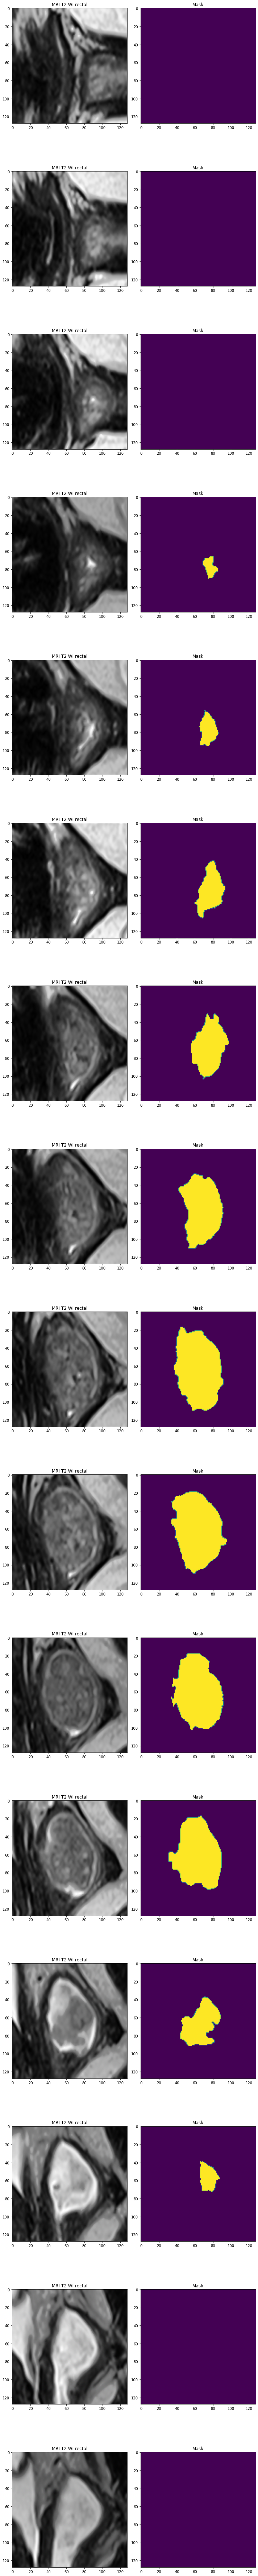

In [9]:
### plot a batch of training images and masks 
batch_train = next(iter(train_loader))
image_visualization(batch_train)

image shape: torch.Size([128, 128, 16]), label shape: torch.Size([128, 128, 16])


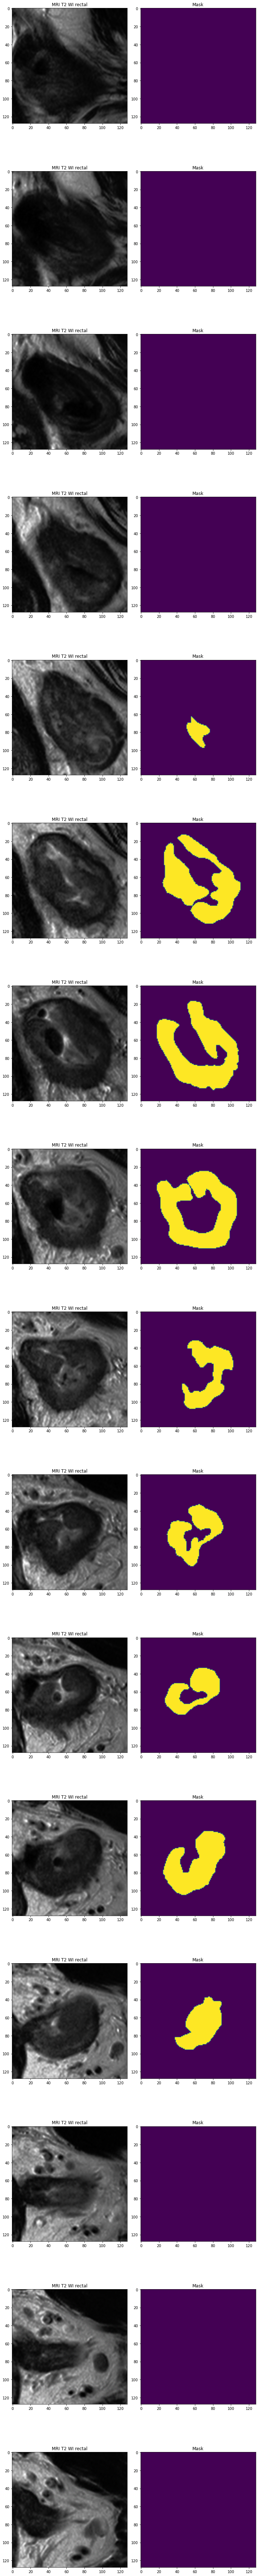

In [10]:
### plot a batch of validation images and masks 
batch_valid = next(iter(val_loader))
image_visualization(batch_valid)

In [11]:
## KI-UNet implementation using MONAI API, by H.Kim, MD.

class kiunet3dwcrfb(nn.Module):
    def __init__(self, c=1, n=1, activation = "PReLU", normalization = "BATCH", num_classes=2, drop_out = None):
        super(kiunet3dwcrfb, self).__init__()

        # Entry flow
        
        #U-NET part
        self.encoder1 = Convolution(dimensions = 3, in_channels = c, out_channels = n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)   
        self.encoder2 = Convolution(dimensions = 3, in_channels = n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False) 
        self.encoder3 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 4*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False) 

        #Ki-NET part
        self.kencoder1 = Convolution(dimensions = 3, in_channels = c, out_channels = n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)
        self.kencoder2 = Convolution(dimensions = 3, in_channels = n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)
        self.kencoder3 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)

        dim = 3
        pool_type, args = split_args(("MAX", {"kernel_size": 2, "stride": 2}))
        self.maxpooling3d = Pool[pool_type, dim](**args)
        
        self.upsample1 = Upsample(dimensions = dim, scale_factor=2, mode = "nontrainable", interp_mode ='trilinear', align_corners=False)         
        self.upsample2 = Upsample(dimensions = dim, scale_factor=4, mode = "nontrainable", interp_mode ='trilinear', align_corners=False) 
        self.upsample3 = Upsample(dimensions = dim, scale_factor=16, mode = "nontrainable", interp_mode ='trilinear', align_corners=False) 
        self.upsample4 = Upsample(dimensions = dim, scale_factor=64, mode = "nontrainable", interp_mode ='trilinear', align_corners=False) 

        self.CRFBupsample1 = Upsample(dimensions = dim, scale_factor=0.25, mode = "nontrainable", interp_mode ='trilinear', align_corners=False)        
        self.CRFBupsample2 = Upsample(dimensions = dim, scale_factor=0.0625, mode = "nontrainable", interp_mode ='trilinear', align_corners=False) 
        self.CRFBupsample3 = Upsample(dimensions = dim, scale_factor=0.015625, mode = "nontrainable", interp_mode ='trilinear',align_corners=False) 
        
        self.decoder1 = Convolution(dimensions = 3, in_channels = 4*n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)     
        self.decoder2 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)
        self.decoder3 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = c, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)     

        self.kdecoder1 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)       
        self.kdecoder2 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)       
        self.kdecoder3 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = c, dropout = drop_out, dropout_dim = 3,
                                     act = activation, norm = normalization, kernel_size = 3, padding = 1, strides = 1, bias = False)      
        
        self.intere1_1 = Convolution(dimensions = 3, in_channels = n, out_channels = n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.intere2_1 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.intere3_1 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 4*n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 

        self.intere1_2 = Convolution(dimensions = 3, in_channels = n, out_channels = n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.intere2_2 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.intere3_2 = Convolution(dimensions = 3, in_channels = 4*n, out_channels = 2*n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 

        self.interd1_1 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation,
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.interd2_1 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation, 
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 


        self.interd1_2 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation, 
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 
        self.interd2_2 = Convolution(dimensions = 3, in_channels = 2*n, out_channels = 2*n, norm = normalization, act = activation, 
                                     dropout = drop_out, dropout_dim = 3, kernel_size = 3, padding = 1, strides = 1) 


        self.seg = Convolution(dimensions = 3, in_channels = c, out_channels = num_classes, dropout = drop_out, dropout_dim = 3,
                               act = activation, norm = normalization, kernel_size = 1, padding = 0, strides = 1, bias = False)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                torch.nn.init.torch.nn.init.kaiming_normal_(m.weight) #
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        out =  self.maxpooling3d(self.encoder1(x))  #U-Net branch layer 1
        out1 = self.upsample1(self.kencoder1(x)) #Ki-Net branch layer 1
        tmp = out
        out = torch.add(out, self.CRFBupsample1(self.intere1_1(out1))) #CRFB1 down
        out1 = torch.add(out1, self.upsample2(self.intere1_2(tmp))) #CRFB1 up
        
        u1 = out  #skip conn
        o1 = out1  #skip conn

        out = self.maxpooling3d(self.encoder2(out)) #U-Net branch layer 2
        out1 = self.upsample1(self.kencoder2(out1)) #Ki-Net branch layer 2
        tmp = out
        out = torch.add(out, self.CRFBupsample2(self.intere2_1(out1))) #CRFB2 down
        out1 = torch.add(out1, self.upsample3(self.intere2_2(tmp))) #CRFB2 up
        
        u2 = out
        o2 = out1

        out = self.maxpooling3d(self.encoder3(out)) #U-Net branch layer 3
        out1 = self.upsample1(self.kencoder3(out1)) #Ki-Net branch layer 3
        tmp = out
        out = torch.add(out, self.CRFBupsample3(self.intere3_1(out1))) #CRFB3 down
        out1 = torch.add(out1, self.upsample4(self.intere3_2(tmp))) #CRFB3 up
        
        ### End of encoder block

        ### Start Decoder
        
        out = self.upsample1(self.decoder1(out)) #U-Net branch layer 1
        out1 = self.maxpooling3d(self.kdecoder1(out1)) #Ki-Net branch layer 1
        tmp = out
        out = torch.add(out, self.CRFBupsample2(self.interd1_1(out1))) #CRFB4 down
        out1 = torch.add(out1, self.upsample3(self.interd1_1(tmp))) #CRFB4 up 
        
        out = torch.add(out,u2)  #skip conn
        out1 = torch.add(out1,o2)  #skip conn

        out = self.upsample1(self.decoder2(out)) #U-Net branch layer 2
        out1 = self.maxpooling3d(self.kdecoder2(out1)) #Ki-Net branch layer 2
        tmp = out
        out = torch.add(out, self.CRFBupsample1(self.interd2_1(out1))) #CRFB5 down 
        out1 = torch.add(out1, self.upsample2(self.interd2_2(tmp))) #CRFB5 up
        
        out = torch.add(out,u1)
        out1 = torch.add(out1,o1)

        out = self.upsample1(self.decoder3(out)) #U-Net branch layer 3
        out1 = self.maxpooling3d(self.kdecoder3(out1)) #Ki-Net branch layer 3
 
        out = torch.add(out,out1) # fusion of both branches
        out = self.seg(out)  #1*1 conv
        return out

In [12]:
## model generation
model = kiunet3dwcrfb(c=1, n=1, num_classes=2, drop_out= 0.2)

In [13]:
### training preparation

if multi_GPU:
    device = torch.device('cuda',0)
    model = torch.nn.DataParallel(model,output_device=0) # wrap the model with DataParallel module
    model.cuda()
else:
    device = torch.device('cuda',0)
    model.cuda()

## loss function and optimizer: DiceLoss and Adam or Novograd optimizer
if fast:
    #speed-up optimizer - Novograd
    loss_function = DiceLoss(to_onehot_y=True, softmax=True).to(device)
    optimizer = Novograd(model.parameters(), lr = 1e-2)
    scaler = torch.cuda.amp.GradScaler()
else:
    loss_function = DiceLoss(to_onehot_y=True, softmax=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2, weight_decay = 0.001)

In [14]:
## train start

epoch_num = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
epoch_time = []
total_start = time.time()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    epoch_start = time.time()
    print("-" * 50)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #set AMP for MONAI training
        if fast:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs,labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        epoch_len = math.ceil(len(train_ds)/train_loader.batch_size)
        print(
            f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
            f" step time: {(time.time() - step_start):.4f} seconds"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (Height, Width, Depth)
                sw_batch_size = 1
                # set AMP for MONAI validation
                if fast:
                    with torch.cuda.amp.autocast():
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                            )
                else:
                    val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model
                        )
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
    print(
        f"time consuming of epoch {epoch + 1} is:"
        f" {(time.time() - epoch_start):.4f} seconds"
        )

--------------------------------------------------
epoch 1/300
1/20, train_loss: 0.6023 step time: 14.2927 seconds
2/20, train_loss: 0.6050 step time: 5.6946 seconds
3/20, train_loss: 0.5754 step time: 5.6761 seconds
4/20, train_loss: 0.6020 step time: 5.8576 seconds
5/20, train_loss: 0.5850 step time: 5.7045 seconds
6/20, train_loss: 0.5748 step time: 5.7441 seconds
7/20, train_loss: 0.6091 step time: 5.7247 seconds
8/20, train_loss: 0.5581 step time: 5.7314 seconds
9/20, train_loss: 0.5601 step time: 5.7430 seconds
10/20, train_loss: 0.6018 step time: 5.7690 seconds
11/20, train_loss: 0.4905 step time: 5.7702 seconds
12/20, train_loss: 0.5366 step time: 5.7600 seconds
13/20, train_loss: 0.5154 step time: 5.7613 seconds
14/20, train_loss: 0.5346 step time: 5.7554 seconds
15/20, train_loss: 0.4618 step time: 5.7920 seconds
16/20, train_loss: 0.5141 step time: 5.7994 seconds
17/20, train_loss: 0.4958 step time: 5.7927 seconds
18/20, train_loss: 0.5547 step time: 5.7829 seconds
19/20, tr

In [15]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4917  at epoch: 156


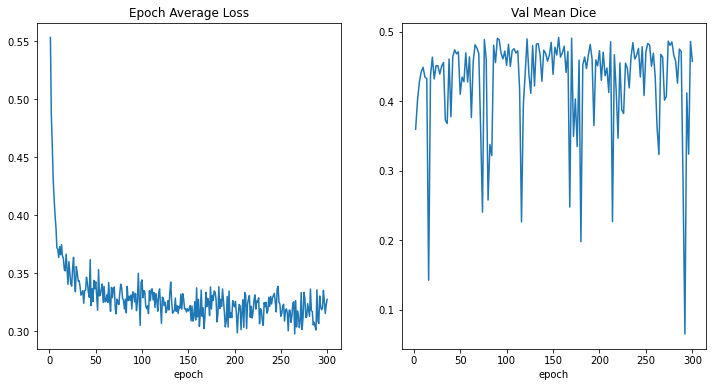

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

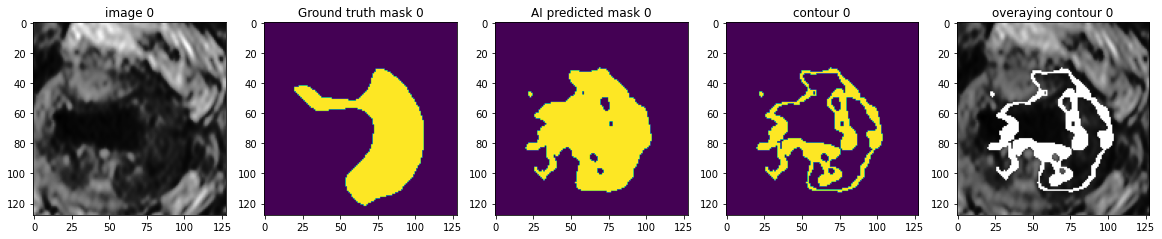

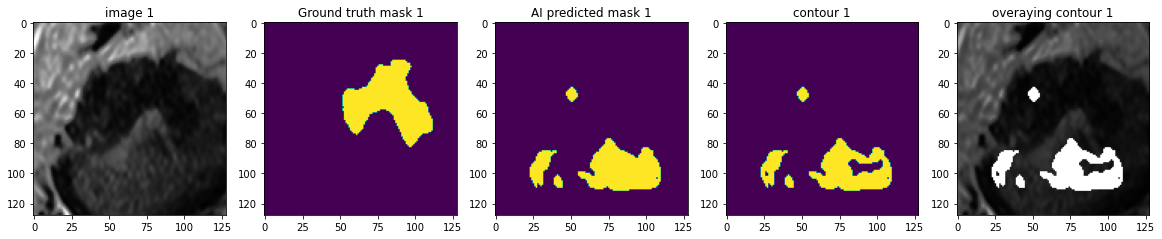

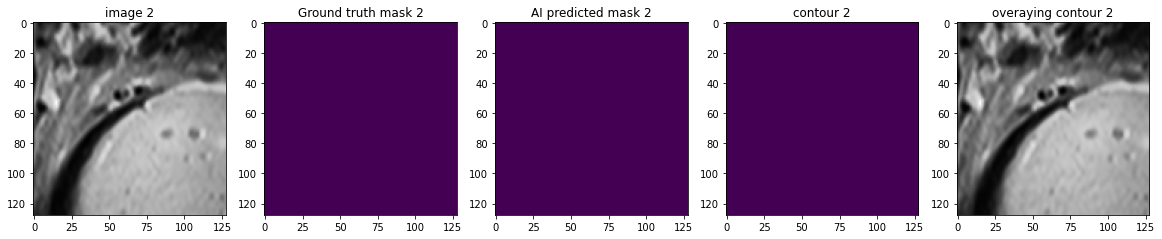

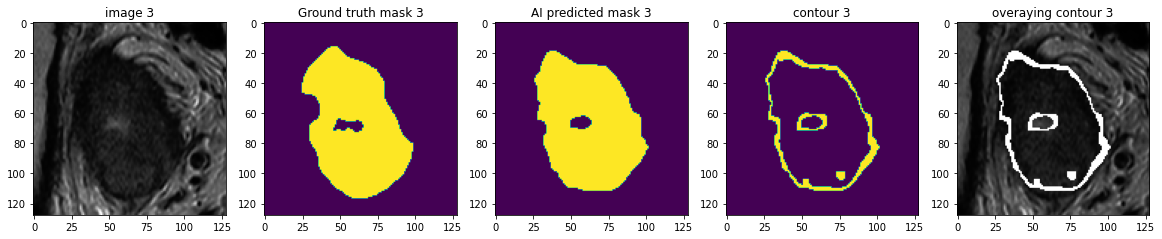

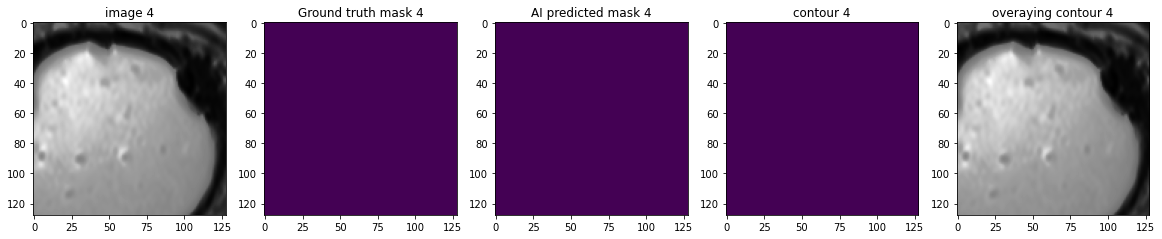

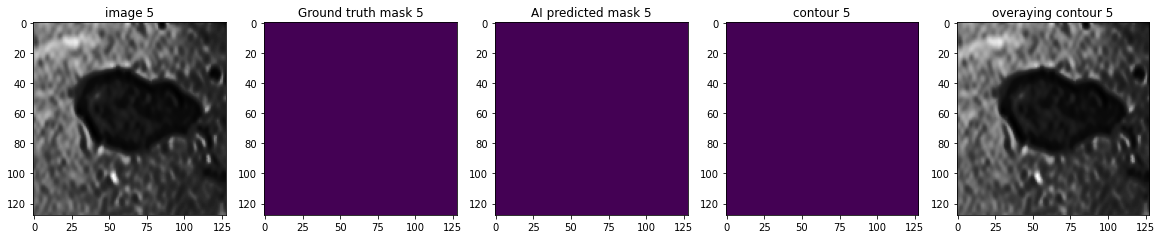

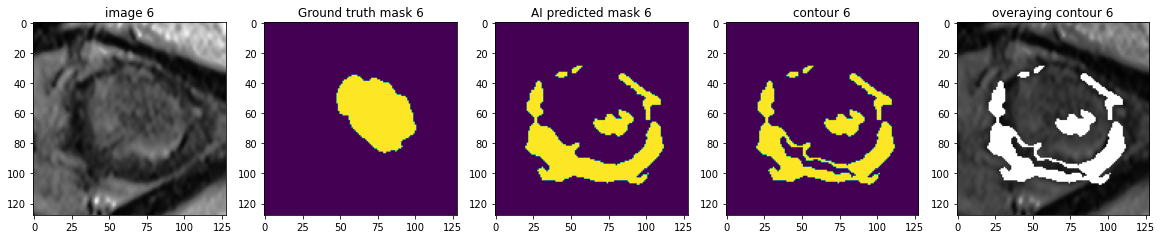

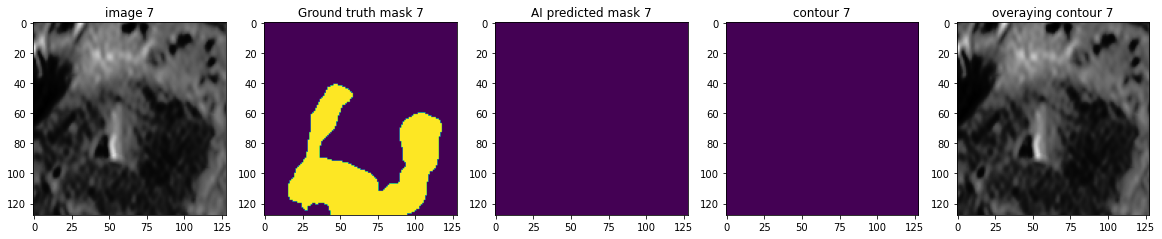

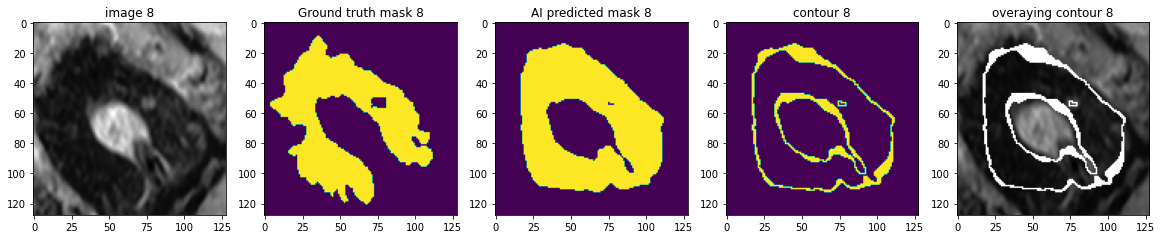

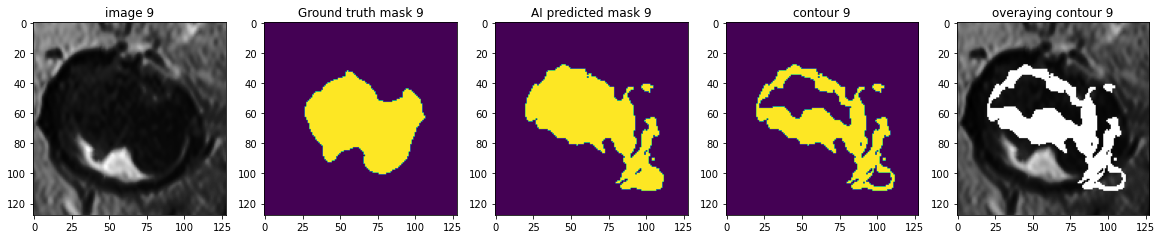

In [17]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (Height, Width, Depth)
        sw_batch_size = 1
        test_image = test_data["image"].to(device)
        test_output = sliding_window_inference(
                        test_image, roi_size, sw_batch_size, model)
        # plot the slice [:, :, rand]
        j = randint(0, len(test_image[0,0,0,0,:])-1)
        plt.figure("check", (20, 4))

        plt.subplot(1, 5, 1)
        plt.title(f"image {i}")
        plt.imshow(test_image.detach().cpu()[0, 0, :, :, j], cmap="gray")

        plt.subplot(1, 5, 2)
        plt.title(f"Ground truth mask {i}")
        plt.imshow(test_data["label"][0, 0, :, :, j])

        plt.subplot(1, 5, 3)
        plt.title(f"AI predicted mask {i}")
        argmax = AsDiscrete(argmax=True)(test_output)
        plt.imshow(argmax.detach().cpu()[0, 0, :, :, j])

        plt.subplot(1, 5, 4)
        plt.title(f"contour {i}")
        contour = LabelToContour()(argmax)
        plt.imshow(contour.detach().cpu()[0, 0, :, :, j])

        plt.subplot(1, 5, 5)
        plt.title(f"overaying contour {i}")
        map_image = test_image.clone().detach()
        map_image[contour==1] = map_image.max()
        plt.imshow(map_image.detach().cpu()[0, 0, :, :, j], cmap="gray")
        plt.show()